In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
import optuna
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import gpytorch
torch.manual_seed(42)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 1.551042261369384), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [3]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [7]:
df.shape

(543, 178)

In [6]:
for col in df.columns:
    print(col)

TAU_bl
PTAU_bl
ABETA_bl
PTEDUCAT
MMSE_bl
EcogPtTotal_bl
LDELTOTAL_BL
mPACCdigit_bl
mPACCtrailsB_bl
RAVLT_immediate_bl
RAVLT_learning_bl
RAVLT_forgetting_bl
SUVr_ACC_pre_L.nii
SUVr_ACC_pre_R.nii
SUVr_ACC_sub_L.nii
SUVr_ACC_sub_R.nii
SUVr_ACC_sup_L.nii
SUVr_ACC_sup_R.nii
SUVr_Amygdala_L.nii
SUVr_Amygdala_R.nii
SUVr_Angular_L.nii
SUVr_Angular_R.nii
SUVr_Calcarine_L.nii
SUVr_Calcarine_R.nii
SUVr_Caudate_L.nii
SUVr_Caudate_R.nii
SUVr_Cerebellum_3_L.nii
SUVr_Cerebellum_3_R.nii
SUVr_Cerebellum_4_5_L.nii
SUVr_Cerebellum_4_5_R.nii
SUVr_Cerebellum_6_L.nii
SUVr_Cerebellum_6_R.nii
SUVr_Cerebellum_7b_L.nii
SUVr_Cerebellum_7b_R.nii
SUVr_Cerebellum_8_L.nii
SUVr_Cerebellum_8_R.nii
SUVr_Cerebellum_9_L.nii
SUVr_Cerebellum_9_R.nii
SUVr_Cerebellum_10_L.nii
SUVr_Cerebellum_10_R.nii
SUVr_Cerebellum_Crus1_L.nii
SUVr_Cerebellum_Crus1_R.nii
SUVr_Cerebellum_Crus2_L.nii
SUVr_Cerebellum_Crus2_R.nii
SUVr_Cingulate_Mid_L.nii
SUVr_Cingulate_Mid_R.nii
SUVr_Cingulate_Post_L.nii
SUVr_Cingulate_Post_R.nii
SUVr_Cuneus_L.

In [5]:

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 3
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
#with torch.no_grad():
#    likelihood.raw_noise.data.fill_(-5.0)
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.5:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00765928291339757, weight_decay = 0.005854636585988225, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=21)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4099368005729661,patience=20)

Model finially intialized with likelihood: -1.4998230934143066


In [8]:
training_loss = []
test_losses = []

In [9]:

num_iter = 1000
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())
    
    optimizer.step()
    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())
    
    scheduler.step(mll(output, y_train))
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()



c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iter 1/1000 - Loss: -1.500
Iter 2/1000 - Loss: -1.496
Iter 3/1000 - Loss: -1.493
Iter 4/1000 - Loss: -1.489
Iter 5/1000 - Loss: -1.486
Iter 6/1000 - Loss: -1.483
Iter 7/1000 - Loss: -1.479
Iter 8/1000 - Loss: -1.476
Iter 9/1000 - Loss: -1.473
Iter 10/1000 - Loss: -1.469
Iter 11/1000 - Loss: -1.466
Iter 12/1000 - Loss: -1.462
Iter 13/1000 - Loss: -1.459
Iter 14/1000 - Loss: -1.456
Iter 15/1000 - Loss: -1.452
Iter 16/1000 - Loss: -1.449
Iter 17/1000 - Loss: -1.446
Iter 18/1000 - Loss: -1.443
Iter 19/1000 - Loss: -1.439
Iter 20/1000 - Loss: -1.436
Iter 21/1000 - Loss: -1.433
Iter 22/1000 - Loss: -1.430
Iter 23/1000 - Loss: -1.427
Iter 24/1000 - Loss: -1.423
Iter 25/1000 - Loss: -1.420
Iter 26/1000 - Loss: -1.417
Iter 27/1000 - Loss: -1.414
Iter 28/1000 - Loss: -1.411
Iter 29/1000 - Loss: -1.408
Iter 30/1000 - Loss: -1.405
Iter 31/1000 - Loss: -1.402
Iter 32/1000 - Loss: -1.399
Iter 33/1000 - Loss: -1.396
Iter 34/1000 - Loss: -1.393
Iter 35/1000 - Loss: -1.390
Iter 36/1000 - Loss: -1.387
I

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

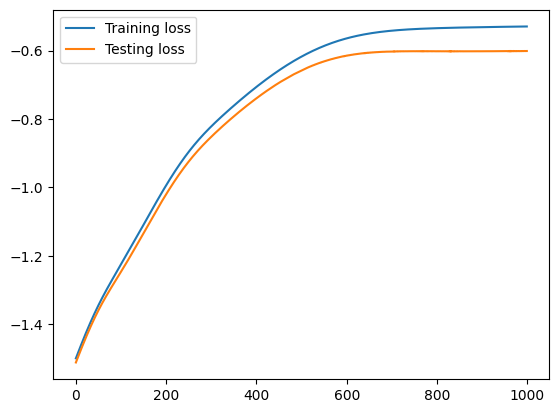

In [10]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [11]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')

Parameter name: likelihood.task_noise_covar_factor         value = [[-0.35575181245803833], [-0.542140007019043], [-0.6081796884536743]]
Parameter name: likelihood.raw_noise                       value = [-5.102104663848877]
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.18897318840026855], [-1.1729825735092163], [-1.1401935815811157]]
Parameter name: covar_module.task_covar_module.raw_var     value = [1.0635621547698975, -4.719062805175781, -3.858248233795166]
Parameter name: covar_module.data_covar_module.raw_lengthscale value = [[4.0511155128479]]
Parameter name: covar_module.data_covar_module.raw_alpha   value = [-2.8969075679779053]


In [12]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0895, RMSE = 0.2992, R2 = 0.9086
Target 2: MSE = 0.1985, RMSE = 0.4455, R2 = 0.7967
Target 3: MSE = 0.2690, RMSE = 0.5186, R2 = 0.7218


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Target 1: MSE = 0.4121, RMSE = 0.6419, R2 = 0.6189
Target 2: MSE = 0.6891, RMSE = 0.8301, R2 = 0.3700
Target 3: MSE = 0.7976, RMSE = 0.8931, R2 = 0.2953


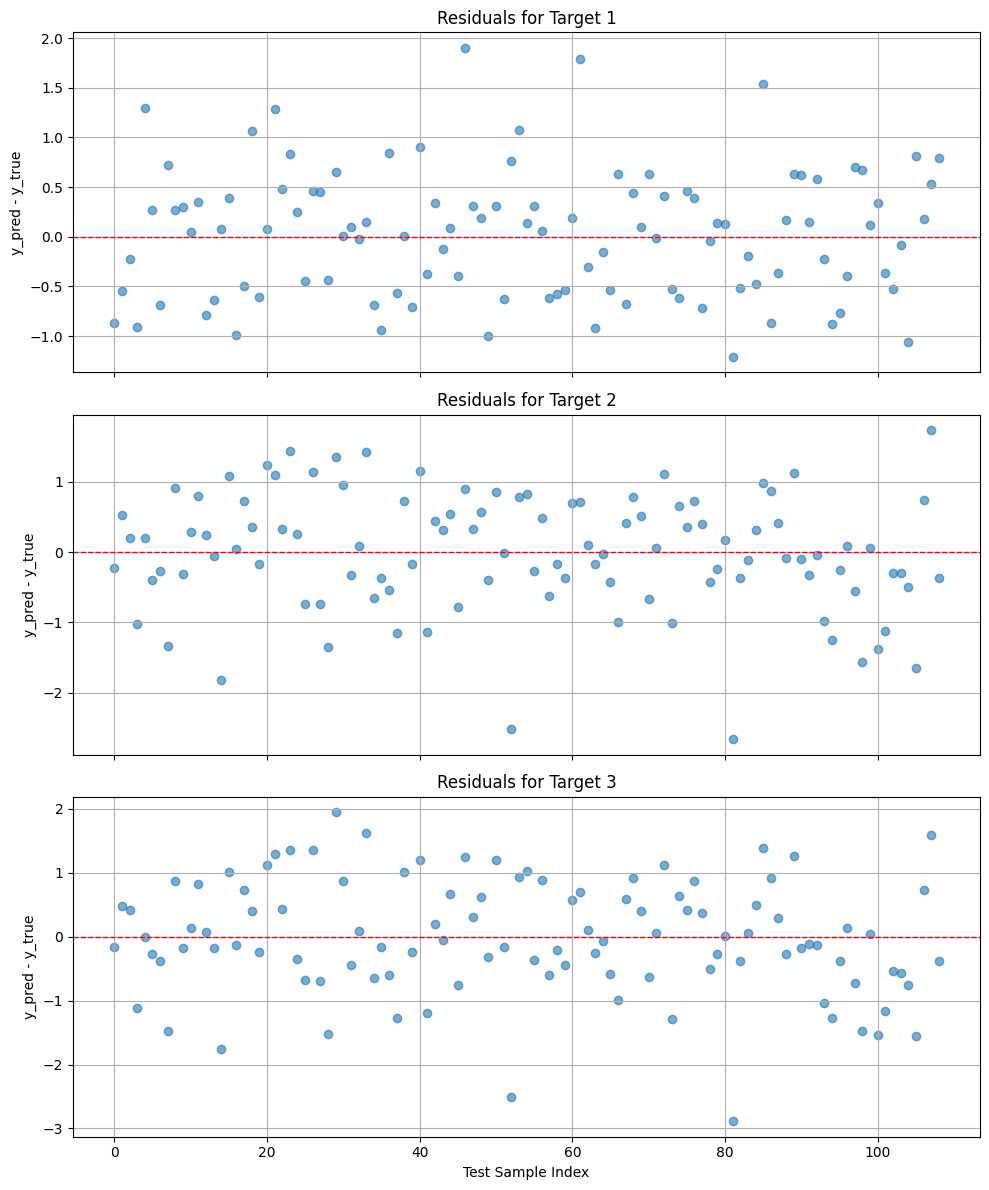

In [13]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

# Plot residuals for each target
fig, axs = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

for i in range(num_targets):
    residuals = y_pred_np[:, i] - y_true_np[:, i]

    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axs[i].set_title(f"Residuals for Target {i+1}")
    axs[i].set_ylabel("y_pred - y_true")
    axs[i].grid(True)

plt.xlabel("Test Sample Index")
plt.tight_layout()
plt.show()

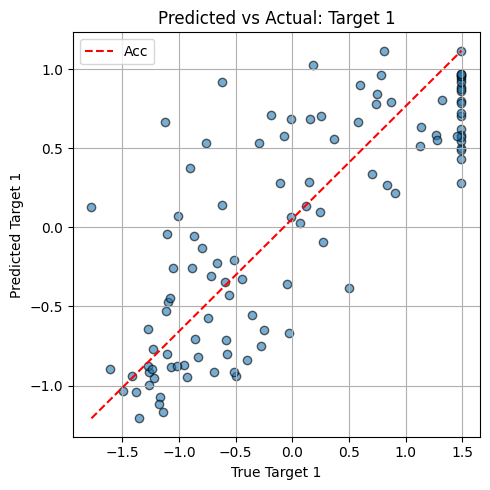

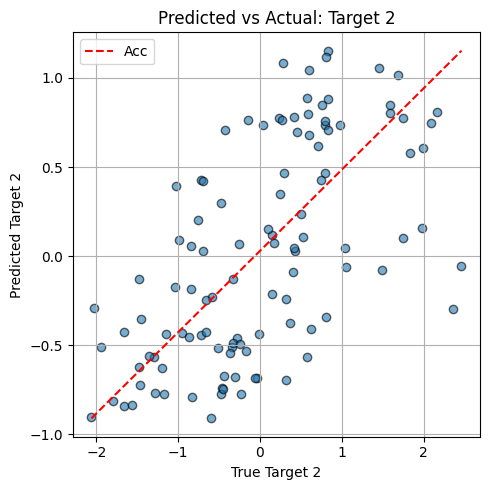

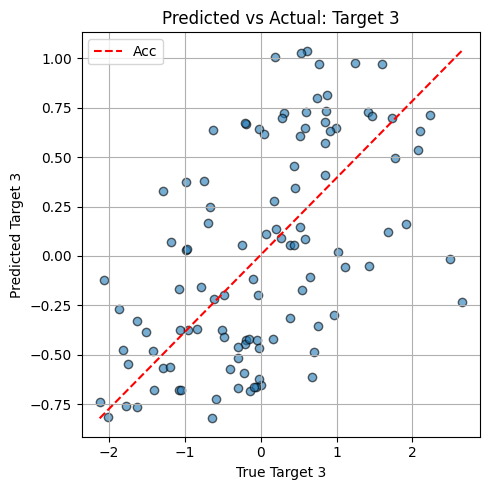

In [14]:
for i in range(y_test.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i].numpy(), mean[:, i].numpy(), alpha=0.6, edgecolors='k')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_pred_np[:, i].min(), y_pred_np[:, i].max()], 'r--', label='Acc')

    plt.xlabel(f"True Target {i+1}")
    plt.ylabel(f"Predicted Target {i+1}")
    plt.title(f"Predicted vs Actual: Target {i+1}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STL



In [15]:
import mrmr

In [149]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 0.010346205016511343,), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [190]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

rs = np.random.randint(1,75)

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['TAU_bl'])

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(rs)

(434, 175) (109, 175) (434, 1) (109, 1)
41


In [191]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [192]:
noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 1
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)

likelihood.noise = 0.5
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.5:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.021413950831352238 , weight_decay= 0.0006757945677703396, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3951543004725355,patience=4)

Model finially intialized with likelihood: -1.3767421245574951


In [193]:
training_loss = []
test_losses = []

num_iter =500
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())
    
    optimizer.step()
    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())
    
    scheduler.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -1.377
Iter 2/500 - Loss: -1.370
Iter 3/500 - Loss: -1.364
Iter 4/500 - Loss: -1.359
Iter 5/500 - Loss: -1.355
Iter 6/500 - Loss: -1.352
Iter 7/500 - Loss: -1.351
Iter 8/500 - Loss: -1.351
Iter 9/500 - Loss: -1.351
Iter 10/500 - Loss: -1.351
Iter 11/500 - Loss: -1.350
Iter 12/500 - Loss: -1.347
Iter 13/500 - Loss: -1.344
Iter 14/500 - Loss: -1.339
Iter 15/500 - Loss: -1.334
Iter 16/500 - Loss: -1.329
Iter 17/500 - Loss: -1.325
Iter 18/500 - Loss: -1.321
Iter 19/500 - Loss: -1.318
Iter 20/500 - Loss: -1.317
Iter 21/500 - Loss: -1.316
Iter 22/500 - Loss: -1.316
Iter 23/500 - Loss: -1.316
Iter 24/500 - Loss: -1.316
Iter 25/500 - Loss: -1.315
Iter 26/500 - Loss: -1.313
Iter 27/500 - Loss: -1.311
Iter 28/500 - Loss: -1.308
Iter 29/500 - Loss: -1.305
Iter 30/500 - Loss: -1.302
Iter 31/500 - Loss: -1.299
Iter 32/500 - Loss: -1.296
Iter 33/500 - Loss: -1.295
Iter 34/500 - Loss: -1.294
Iter 35/500 - Loss: -1.293
Iter 36/500 - Loss: -1.293
Iter 37/500 - Loss: -1.293
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

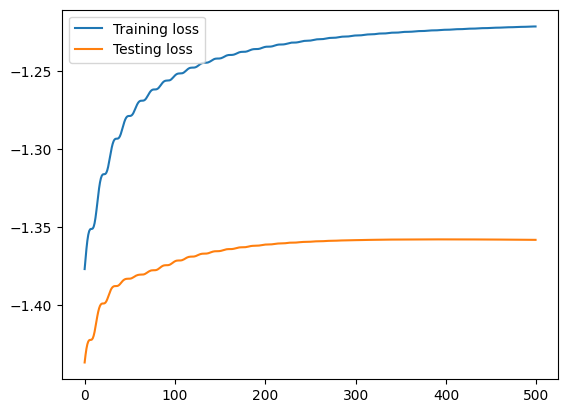

In [194]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [195]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"TRAIN:\n Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

TRAIN:
 Target 1: MSE = 0.0149, RMSE = 0.1219, R2 = 0.9846


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [196]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"TEST:\n Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

TEST:
 Target 1: MSE = 0.7958, RMSE = 0.8921, R2 = 0.2969


# Optimisation

In [144]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


(434, 175) (109, 175) (434, 1) (109, 1)


In [145]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # weight_decay = 1e-4
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    #scheduler_type = trial.suggest_categorical("scheduler", ["CosineAnnealingLR"])
    scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])
    lengthscale = trial.suggest_float("lengthscale", 1e-2, 1e1, log=True)

    num_tasks = 1
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)

    class TrialMultitaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, num_tasks):
            super(TrialMultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.MultitaskMean(
                gpytorch.means.ZeroMean(), num_tasks=num_tasks
            )
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale), num_tasks=num_tasks, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    model = TrialMultitaskGPModel(X_train, y_train, likelihood, num_tasks)


    # Configure optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9, maximize=True)

    # Configure scheduler
    if scheduler_type == "ReduceLROnPlateau":
        factor = trial.suggest_float("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 3, 20)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    elif scheduler_type == "StepLR":
        step_size = trial.suggest_int("step_size", 5, 50)
        gamma = trial.suggest_float("gamma", 0.1, 0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        t_max = trial.suggest_int("t_max", 5, 50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train)
    while initial_likelihood < -2.0:
        model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
        initial_likelihood = mll(model(X_train), y_train)
    print(f'Model finially intialized with likelihood: {initial_likelihood}')

    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500  # You could also make this a hyperparameter
    
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train)
        loss.backward()
        optimizer.step()

        # Handle different scheduler types
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(mll(output, y_train))  # Pass validation metric
        else:
            scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate mean R² across all targets
    r2_values = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(num_tasks)]
    mean_r2 = np.mean(r2_values)

    return mean_r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-03 11:00:16,222] A new study created in memory with name: no-name-4b27e533-e7e9-4053-b3f0-9cd7964d4b3f


Model finially intialized with likelihood: -1.6857008934020996


[I 2025-07-03 11:00:52,098] Trial 0 finished with value: 0.2949531674385071 and parameters: {'lr': 0.0009238167492705642, 'weight_decay': 0.0021610315501681514, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.01043594222957432, 'factor': 0.14258032489726818, 'patience': 17}. Best is trial 0 with value: 0.2949531674385071.


Model finially intialized with likelihood: -1.441197395324707


[I 2025-07-03 11:01:26,703] Trial 1 finished with value: 0.2649765610694885 and parameters: {'lr': 0.000610568123470644, 'weight_decay': 1.6846937310693726e-05, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 7.088785283616163, 'factor': 0.6649584248909878, 'patience': 14}. Best is trial 0 with value: 0.2949531674385071.


Model finially intialized with likelihood: -1.8160697221755981


[I 2025-07-03 11:02:02,175] Trial 2 finished with value: 0.14898109436035156 and parameters: {'lr': 0.00015583899916513943, 'weight_decay': 0.0013170923983381432, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 5.036784084997293, 'factor': 0.4248852681158357, 'patience': 8}. Best is trial 0 with value: 0.2949531674385071.


Model finially intialized with likelihood: -1.951625943183899


[I 2025-07-03 11:02:25,254] Trial 3 finished with value: 0.4234775900840759 and parameters: {'lr': 0.021413950831352238, 'weight_decay': 0.0006757945677703396, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 0.010346205016511343, 't_max': 7}. Best is trial 3 with value: 0.4234775900840759.


Model finially intialized with likelihood: -1.6687002182006836


[I 2025-07-03 11:02:48,954] Trial 4 finished with value: 0.27307385206222534 and parameters: {'lr': 0.000387563541462443, 'weight_decay': 0.002635909880104616, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 0.07493768307399054, 't_max': 9}. Best is trial 3 with value: 0.4234775900840759.
[I 2025-07-03 11:02:49,054] Trial 5 pruned. 


Model finially intialized with likelihood: -1.6245189905166626
Model finially intialized with likelihood: -1.6704851388931274


[I 2025-07-03 11:02:49,220] Trial 6 pruned. 
[I 2025-07-03 11:02:49,304] Trial 7 pruned. 
[I 2025-07-03 11:02:49,396] Trial 8 pruned. 


Model finially intialized with likelihood: -1.6503318548202515
Model finially intialized with likelihood: -1.4524661302566528
Model finially intialized with likelihood: -1.6295949220657349


[I 2025-07-03 11:02:49,486] Trial 9 pruned. 
[I 2025-07-03 11:02:49,596] Trial 10 pruned. 
[I 2025-07-03 11:02:49,722] Trial 11 pruned. 


Model finially intialized with likelihood: -1.5718235969543457
Model finially intialized with likelihood: -1.4316126108169556


[I 2025-07-03 11:02:49,837] Trial 12 pruned. 


Model finially intialized with likelihood: -1.5238136053085327
Model finially intialized with likelihood: -1.7373788356781006


[I 2025-07-03 11:03:27,969] Trial 13 finished with value: 0.37761247158050537 and parameters: {'lr': 0.0020895311847054705, 'weight_decay': 0.006306295600981074, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.7990175111382658, 'factor': 0.3536506664224084, 'patience': 6}. Best is trial 3 with value: 0.4234775900840759.
[I 2025-07-03 11:03:28,081] Trial 14 pruned. 


Model finially intialized with likelihood: -1.405073642730713
Model finially intialized with likelihood: -1.7962483167648315


[I 2025-07-03 11:04:04,327] Trial 15 finished with value: 0.3871060013771057 and parameters: {'lr': 0.002091979324948763, 'weight_decay': 0.00014014572016517694, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 1.361361656422589, 'factor': 0.42124316539849693, 'patience': 3}. Best is trial 3 with value: 0.4234775900840759.
[I 2025-07-03 11:04:04,425] Trial 16 pruned. 
[I 2025-07-03 11:04:04,554] Trial 17 pruned. 


Model finially intialized with likelihood: -1.7317981719970703
Model finially intialized with likelihood: -1.3855091333389282


[I 2025-07-03 11:04:04,658] Trial 18 pruned. 
[I 2025-07-03 11:04:04,779] Trial 19 pruned. 


Model finially intialized with likelihood: -1.5917595624923706
Model finially intialized with likelihood: -1.6094125509262085


[I 2025-07-03 11:04:04,904] Trial 20 pruned. 


Model finially intialized with likelihood: -1.5942072868347168
Model finially intialized with likelihood: -1.5079888105392456


[I 2025-07-03 11:04:05,042] Trial 21 pruned. 
[I 2025-07-03 11:04:05,175] Trial 22 pruned. 


Model finially intialized with likelihood: -1.6575502157211304
Model finially intialized with likelihood: -1.5092600584030151


[I 2025-07-03 11:04:05,304] Trial 23 pruned. 
[I 2025-07-03 11:04:05,447] Trial 24 pruned. 
[I 2025-07-03 11:04:05,570] Trial 25 pruned. 


Model finially intialized with likelihood: -1.4520084857940674
Model finially intialized with likelihood: -1.458066701889038


[I 2025-07-03 11:04:05,683] Trial 26 pruned. 


Model finially intialized with likelihood: -1.626636028289795
Model finially intialized with likelihood: -1.7562015056610107


[I 2025-07-03 11:04:40,248] Trial 27 finished with value: 0.3979293704032898 and parameters: {'lr': 0.004551230325731094, 'weight_decay': 0.005132825808085235, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.11858035544216923, 'factor': 0.26735811431634104, 'patience': 11}. Best is trial 3 with value: 0.4234775900840759.
[I 2025-07-03 11:04:40,340] Trial 28 pruned. 
[I 2025-07-03 11:04:40,477] Trial 29 pruned. 


Model finially intialized with likelihood: -1.655095100402832
Model finially intialized with likelihood: -1.7000623941421509
Model finially intialized with likelihood: -1.8716694116592407


[I 2025-07-03 11:05:15,104] Trial 30 finished with value: 0.41059398651123047 and parameters: {'lr': 0.030213807923628717, 'weight_decay': 0.0006760566508792864, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.01959486149726512, 'factor': 0.2206023550101323, 'patience': 13}. Best is trial 3 with value: 0.4234775900840759.
[I 2025-07-03 11:05:15,228] Trial 31 pruned. 
[I 2025-07-03 11:05:15,337] Trial 32 pruned. 


Model finially intialized with likelihood: -1.6020537614822388
Model finially intialized with likelihood: -1.5949089527130127


[I 2025-07-03 11:05:15,478] Trial 33 pruned. 
[I 2025-07-03 11:05:15,596] Trial 34 pruned. 


Model finially intialized with likelihood: -1.4111428260803223
Model finially intialized with likelihood: -1.4093403816223145


[I 2025-07-03 11:05:15,730] Trial 35 pruned. 
[I 2025-07-03 11:05:15,854] Trial 36 pruned. 


Model finially intialized with likelihood: -1.5938047170639038
Model finially intialized with likelihood: -1.6670140027999878


[W 2025-07-03 11:07:12,074] Trial 37 failed with parameters: {'lr': 0.0002659490166511775, 'weight_decay': 8.588279302366966e-05, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.11440040951505538, 'factor': 0.28797604213370903, 'patience': 18} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\huw\AppData\Local\Temp\ipykernel_27812\2583194605.py", line 62, in objective
    initial_likelihood = mll(model(X_train), y_train)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\module.py", line 82, in __call__
    outputs = self.forward(*inputs, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 